### Heuristic Models
Look at the Seattle weather in the **data** folder. Come up with a heuristic model to predict if it will rain today. Keep in mind this is a time series, which means that you only know what happened historically (before a given date). One example of a heuristic model is: It will rain tomorrow if it rained more than 1 inch (>1.0 PRCP) today. Describe your heuristic model in the next cell.

If minmum tempatrue of yesterday was below the the average, it will rain today.
If PRCP > 0, then it will be rain 

Examples:  
It will rain tomorrow if it rained more than 1 inch (>1.0 PRCP) today
If rained yesterday it will rain today.  
If it rained yesterday or the day before it will rain today.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics



In [58]:
#here is an example of how to build and populate a hurestic model


df = pd.read_csv('../data/seattle_weather_1948-2017.csv')

numrows = 25549 # can be as large as 25549

#create an empty dataframe to hold 100 values
heuristic_df = pd.DataFrame({'yesterday':[0.0]*numrows,
                             'today':[0.0]*numrows,
                             'tomorrow':[0.0]*numrows,
                             'guess':[False]*numrows, #logical guess
                             'rain_tomorrow':[False]*numrows, #historical observation
                             'correct':[False]*numrows}) #TRUE if your guess matches the historical observation

#sort columns for convience
seq = ['yesterday','today','tomorrow','guess','rain_tomorrow','correct']
heuristic_df = heuristic_df.reindex(columns=seq)

In [59]:
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [60]:
heuristic_df.head()

,yesterday,today,tomorrow,guess,rain_tomorrow,correct
0,0.0,0.0,0.0,False,False,False
1,0.0,0.0,0.0,False,False,False
2,0.0,0.0,0.0,False,False,False
3,0.0,0.0,0.0,False,False,False
4,0.0,0.0,0.0,False,False,False


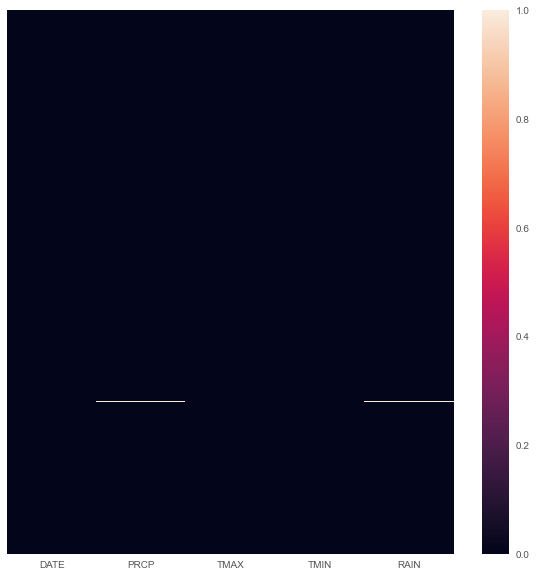

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.isnull(df),yticklabels=False)

In [62]:
df[pd.isnull(df['PRCP'])]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [63]:
df[pd.isnull(df['RAIN'])]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


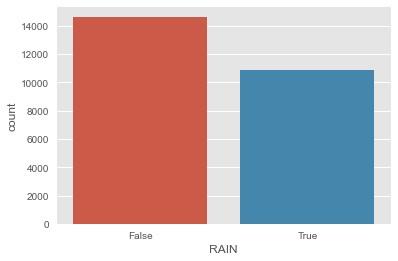

In [64]:
sns.countplot(data=df, x='RAIN')

In [65]:
df['PRCP'].mean()

0.10622162204477956

In [66]:
# Replace null values with False

def RAIN_INSERTION(cols):
    RAIN=cols[0]
    if pd.isnull(RAIN):
        return 'False'
    else:
        return RAIN

In [67]:
# Replace null values with the mean

def PRCP_INSERTION(col):
    PRCP=col[0]
    if pd.isnull(PRCP):
        return df['PRCP'].mean()
    else:
        return PRCP

In [68]:
df['RAIN']=df[['RAIN']].apply(RAIN_INSERTION,axis=1)

In [69]:
df['PRCP']=df[['PRCP']].apply(PRCP_INSERTION,axis=1)

In [70]:
df[pd.isnull(df['RAIN'])]

,DATE,PRCP,TMAX,TMIN,RAIN


In [71]:
df[pd.isnull(df['PRCP'])]

,DATE,PRCP,TMAX,TMIN,RAIN


## EDA

Text(0.5, 1.0, 'Precipitation Vs Minimum Temperature')

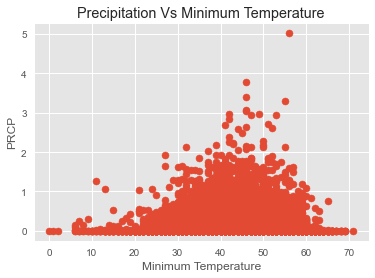

In [72]:
plt.scatter(x='TMIN',y='PRCP',data=df)
plt.xlabel('Minimum Temperature')
plt.ylabel('PRCP')
plt.title('Precipitation Vs Minimum Temperature')

Text(0.5, 1.0, 'Precipitation Vs Maximum Temperature')

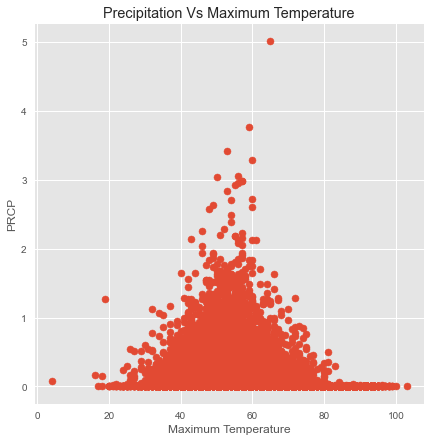

In [73]:
plt.figure(figsize=(7,7))
plt.scatter(x='TMAX',y='PRCP',data=df)
plt.xlabel('Maximum Temperature')
plt.ylabel('PRCP')
plt.title('Precipitation Vs Maximum Temperature')


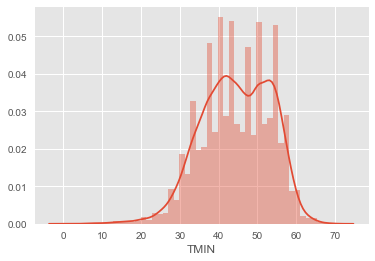

In [74]:
sns.distplot(df['TMIN'])

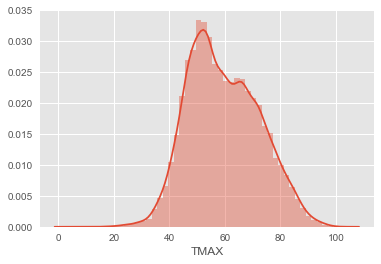

In [75]:
sns.distplot(df['TMAX'])

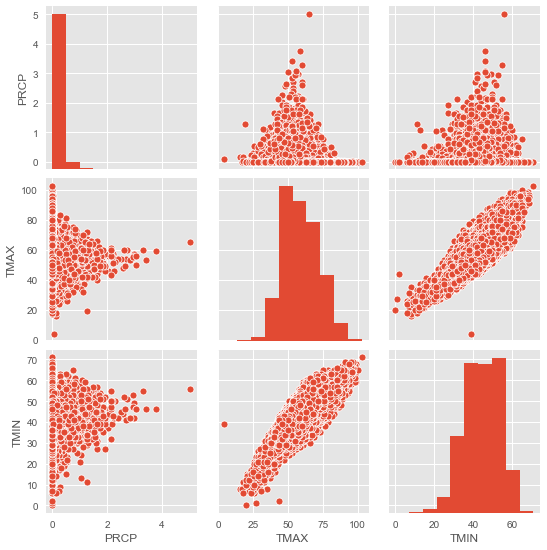

In [76]:
sns.pairplot(data=df)

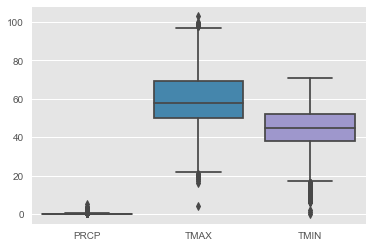

In [77]:
#plt.figure(figsize=(10,7))
sns.boxplot(data=df)

In [78]:
#Dropping the outliers from TMIN column
df=df.drop(df[df['TMIN']<17 ].index)


In [79]:
#Dropping the outliers from TMAX columns i.e. the value more than 100
df=df.drop(df[(df['TMAX']>97.5) | (df['TMAX']< 21.5)].index)


In [80]:
#Dropping the outliers from PRCP columns i.e. the value more than 0.275
df=df.drop(df[(df['PRCP']>0.25) | (df['PRCP']< -0.15) ].index)

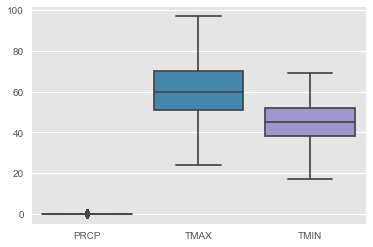

In [81]:
sns.boxplot(data=df)


# Heuristic model

Build a loop to add your heuristic model guesses as a column to this dataframe

In [82]:
# here is an example loop that populates the dataframe created earlier
# with the total percip from yesterday and today
# then the guess is set to true if rained both yesterday and today 
for z in range(numrows):
    #start at time 2 in the data frame
    i = z + 2
    
    #pull values from the dataframe
    yesterday = df.iloc[(i-2),1]
    today = df.iloc[(i-1),1]
    tomorrow = df.iloc[i,1]
    rain_tomorrow = df.iloc[(i),1]

    
    heuristic_df.iat[z,0] = yesterday
    heuristic_df.iat[z,1] = today
    heuristic_df.iat[z,2] = tomorrow
    heuristic_df.iat[z,3] = False # set guess default to False
    heuristic_df.iat[z,4] = rain_tomorrow
    
    
    ######### uncomment and create your heuristic guess ################
    #if ##### your conditions here #########:
    #    heuristic_df.iat[z,3] = True 
    ####################################################################
    
    if heuristic_df.iat[z,3] == heuristic_df.iat[z,4]:
        heuristic_df.iat[z,5] = True
    else:
        heuristic_df.iat[z,5] = False

IndexError: single positional indexer is out-of-bounds

### Evaluate the performance of the Heuristic model

***the accuracy of your predicitions***

In [91]:
heuristic_df['correct'].value_counts()/numrows

True     0.57012
False    0.42988
Name: correct, dtype: float64

# Logistic regression is one of the classification algorithms

In [ ]:
lr= LogisticRegression()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X=df.drop(['RAIN','DATE'],axis=1)
y=df['RAIN'] # target varable
y=y.astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
prediction=lr.predict(X_test)

## Compute confusion matrix and classification_report to evaluate the accuracy of a classification.

In [88]:
print('Confusion Matrix',confusion_matrix(y_test,prediction))
print('\n')
print('Classification Report',classification_report(y_test,prediction))

Confusion Matrix [[4350   21]
 [ 537 1660]]


Classification Report               precision    recall  f1-score   support

       False       0.89      1.00      0.94      4371
        True       0.99      0.76      0.86      2197

    accuracy                           0.92      6568
   macro avg       0.94      0.88      0.90      6568
weighted avg       0.92      0.92      0.91      6568



In confusion_matrix
- actual values is rain and predicated rain 4338
- actual values is not rain and predicated rain 28

- actual values is rain and predicated not rain 561
- actual values is not rain and predicated not rain 2739

In [89]:

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, prediction))

Accuracy: 0.9150426309378806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:189: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


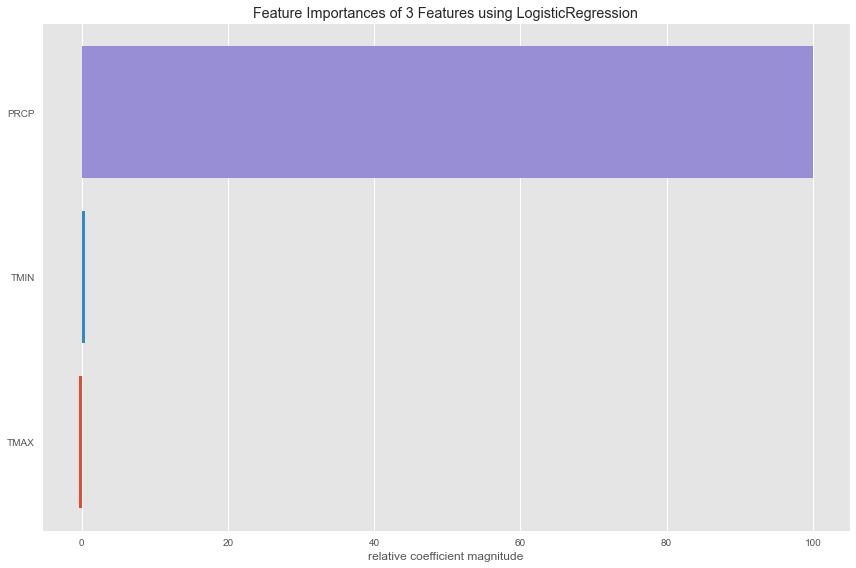

In [90]:
model = LogisticRegression(multi_class="auto", solver="liblinear")
viz = FeatureImportances(model)
viz.fit(X_train,y_train)
viz.show()

# Random Forest Classifier

In [83]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)


In [84]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [85]:

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9996954933008526


In [86]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


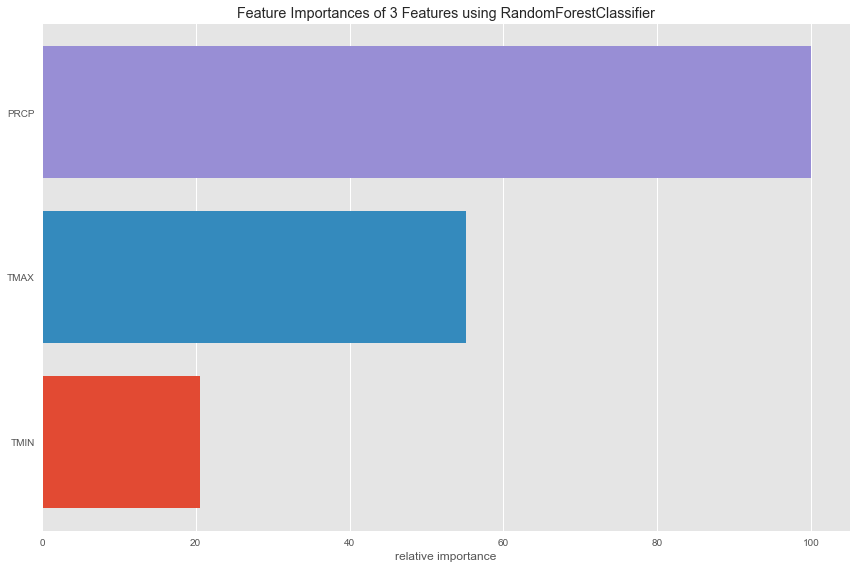

In [87]:
rf = RandomForestClassifier(bootstrap='True', 
                            max_depth=2, 
                            n_jobs=1, 
                            random_state=0,
                            verbose=False)
viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();